# LSTM Networks

In [2]:
#import packages
import pandas as pd
import numpy as np
import datetime

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


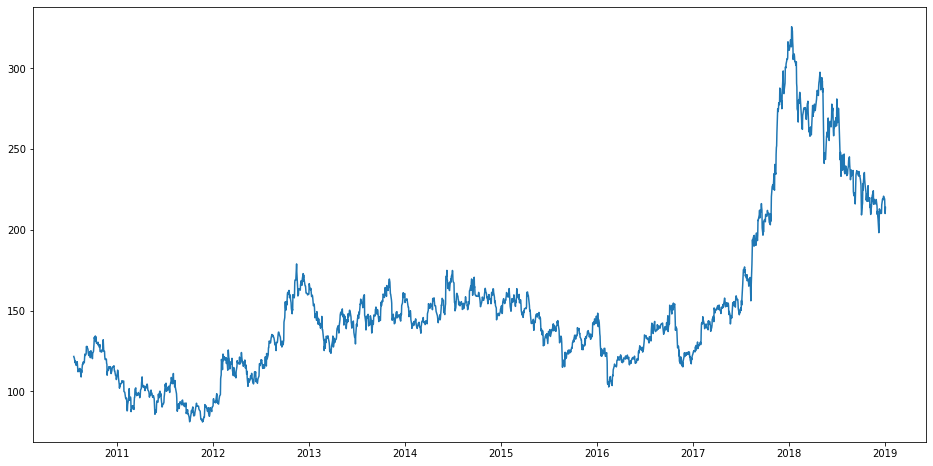

In [3]:
#read the file
df = pd.read_csv('NSE-TATAGLOBAL.csv')

#print the head
df.head()

#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

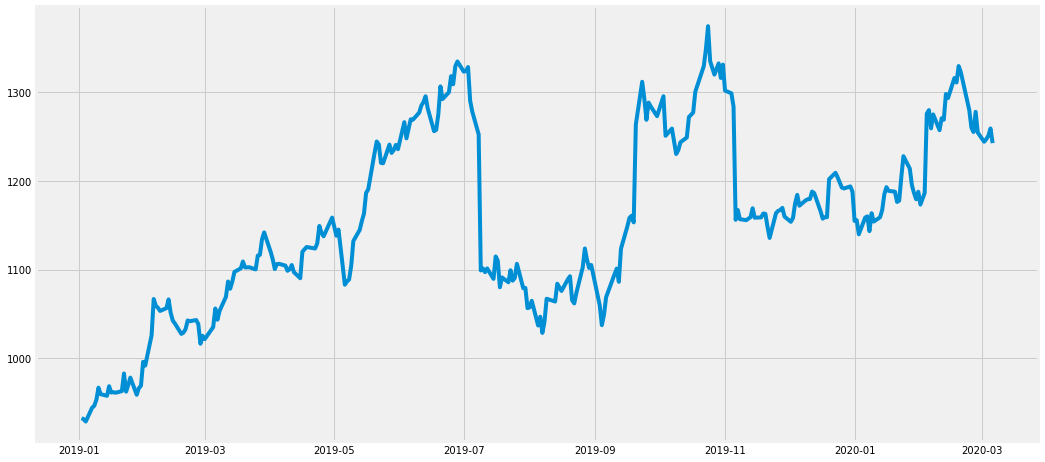

In [259]:
nifty = pd.read_csv("/Users/rshah181/Desktop/AMADEUS/NIFTY100/TITAN.csv").fillna(0)
nifty['Date'] = nifty['date'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
nifty.drop(columns=['datetime', 'volume', 'time', 'date'], inplace=True)
nifty = nifty[(nifty['Date'] > datetime.datetime.strptime('2019-01-01', '%Y-%m-%d'))]
nifty.index = nifty['Date']
nifty.columns = 'Open High Low Close Date'.split()

df = nifty

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [4]:
lookback = 60

In [5]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = data[['Close']]

#creating train and test sets
dataset = new_data.values

train = dataset[0:int(len(dataset)/2),:]
valid = dataset[int(len(dataset)/2):,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(lookback,len(train)):
    x_train.append(scaled_data[i-lookback:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past lookback from the train data
inputs = new_data[len(new_data) - len(valid) - lookback:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(lookback,inputs.shape[0]):
    X_test.append(inputs[i-lookback:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Using TensorFlow backend.


Epoch 1/1
 - 26s - loss: 8.4975e-04


In [6]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

12.221123306530078

In [10]:
valid_

,Close,Predictions
Date,,
2014-10-07,158.80,154.931549
2014-10-08,160.25,154.321274
2014-10-09,161.25,154.117615
2014-10-10,160.25,154.282806
2014-10-13,157.50,154.469177
...,...,...
2018-12-31,219.40,206.511307
2019-01-01,219.10,207.281647
2019-01-02,214.60,207.639069


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


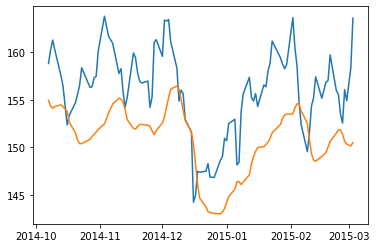

In [12]:
#for plotting
train_ = new_data[0:int(len(dataset)/2)]
valid_ = new_data[int(len(dataset)/2):]
valid_['Predictions'] = closing_price
# plt.plot(train_['Close'])
plt.plot(valid_[['Close','Predictions']].iloc[:100])

***